This is the ED code of $N_1 \times N_2$ Kitaev model. Here we use scipy.sparse to generate the Hamiltonian matrix.

\section{Kitaev Hamiltonian}

\begin{equation}
    H_K = - \sum_{<j,k>_\alpha} J_\alpha S_j^\alpha S_k^\alpha
\end{equation}
where $\alpha = x, y, z$.

In [6]:
import numpy as np
import scipy.sparse as sps
from scipy.sparse import identity
from scipy.sparse.linalg import eigsh

def unit(N):
    p = identity(pow(2,N))
    return p

def index(N1, N2, c, r, atom = 'A'):
    '''Calculate the index of the atoms in the (r,c) unit cell'''
    c = c % N1
    r = r % N2
    
    n = r * N1 + c
    if atom == 'A':
        ind = 2 * n
    elif atom == 'B':
        ind = 2 * n + 1
    else:
        return print('ERROR: The atom index should be A or B.')
    return ind

def KitaevRhom_sparse(J, N1, N2): #default periodic boundary condition
    
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    Hk = sps.csc_matrix((dim,dim))
    
    # define Pauli matrices
    sx = sps.csc_matrix(0.5 * np.array([[0,1],[1,0]]))
    sy = sps.csc_matrix(0.5 * np.array([[0,-1j],[1j,0]]))
    sz = sps.csc_matrix(0.5 * np.array([[1,0],[0,-1]]))
    
    # interactions
    SxSx = -J[0] * sps.kron(sx,sx)
    
    SySy = -J[1] * sps.kron(sy,sy)
    
    midy_b = index(N1, N2, -1, 0, atom = 'B') - index(N1, N2, 0, 0, atom = 'A')
    SySy_b = -J[1] * sps.kron(sy, sps.kron(unit(midy_b - 1), sy))
                      
    midz = index(N1, N2, 0, 1, atom = 'A') - index(N1, N2, 0, 0, atom = 'B')
    SzSz = -J[2] * sps.kron(sz, sps.kron(unit(midz - 1), sz))
    
    midz_b = index(N1, N2, 0, -1, atom = 'B') - index(N1, N2, 0, 0, atom = 'A')
    SzSz_b = -J[2] * sps.kron(sz, sps.kron(unit(midz_b - 1), sz))
        
    # define Kitaev Hamiltonian
    for r in range(N2):
        for c in range(N1):
            n = index(N1, N2, c, r, atom = 'A')
            '''Sx - Sx'''
            Hk += sps.kron(unit(n), sps.kron(SxSx, unit(SiteNum - n - 2)))
            
            '''Sy - Sy'''
            if c == 0:
                Hk += sps.kron(unit(n), sps.kron(SySy_b, unit(SiteNum - n - midy_b -1)))
            else:
                Hk += sps.kron(unit(n-1), sps.kron(SySy, unit(SiteNum - n - 1)))
    
            '''Sz-Sz'''
            if r == 0:
                Hk += sps.kron(unit(n), sps.kron(SzSz_b,unit(SiteNum - n - midz_b - 1)))
            else:
                Hk += sps.kron(unit(n - midz), sps.kron(SzSz, unit(SiteNum - n - 1)))
    return Hk


In [45]:
'''TEST CODE'''
J = -np.ones(3)
N1 = 2
N2 = 3
SiteNum = N1 * N2 * 2
Hk = KitaevRhom_sparse(J, N1, N2)
from scipy.sparse.linalg import eigsh
e,v = eigsh(Hk, k = 5,which = 'SA')
print(e/SiteNum)

[-0.20417256 -0.20417256 -0.19523157 -0.20417256 -0.20417256]


In [8]:
np.where(np.min(e))

(array([0]),)

\section{The magnetic field Hamiltonian}

\quad The magnetic field Hamiltonian is:

\begin{equation}
    H_h = - \sum_j \vec{h} \cdot \vec{S_j} = - \sum_{j,\alpha} h_\alpha S_j^\alpha, \ \ \alpha= x, y, z
\end{equation}

In [9]:
def MagHam_sparse(field, N1, N2):
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    Hm = sps.csc_matrix((dim,dim))
    
    # define Pauli matrices
    sx = sps.csc_matrix(0.5 * np.array([[0,1],[1,0]]))
    sy = sps.csc_matrix(0.5 * np.array([[0,-1j],[1j,0]]))
    sz = sps.csc_matrix(0.5 * np.array([[1,0],[0,-1]]))
    
    # define spin operators
    sj = -field[0]*sx - field[1]*sy - field[2]*sz
    
    for n in range(SiteNum):
        Hm += sps.kron(unit(n), sps.kron(sj, unit(SiteNum - n - 1)))   
    return Hm

def magnetization(state, N1, N2):
    s = np.zeros(4,dtype = complex)
    
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    Sx = sps.csc_matrix((dim,dim))
    Sy = sps.csc_matrix((dim,dim))
    Sz = sps.csc_matrix((dim,dim))
    
    # define Pauli matrices
    sx = sps.csc_matrix(0.5 * np.array([[0,1],[1,0]]))
    sy = sps.csc_matrix(0.5 * np.array([[0,-1j],[1j,0]]))
    sz = sps.csc_matrix(0.5 * np.array([[1,0],[0,-1]]))
    
    for n in range(SiteNum):
        Sx += sps.kron(unit(n), sps.kron(sx, unit(SiteNum - n - 1)))
        Sy += sps.kron(unit(n), sps.kron(sy, unit(SiteNum - n - 1)))
        Sz += sps.kron(unit(n), sps.kron(sz, unit(SiteNum - n - 1)))
       
    s[0] = np.conj(state).T @ Sx @ state
    s[1] = np.conj(state).T @ Sy @ state
    s[2] = np.conj(state).T @ Sz @ state
    
    for i in range(3):
        s[3] += np.conj(s[i]) * s[i]
    s[3] = np.sqrt(s[3])
    
    return s/SiteNum

\subsection{KSL under a uniform magnetic field}

In [10]:
'''TEST CODE'''
from scipy.sparse.linalg import eigsh

J = -np.ones(3)
N1 = 2
N2 = 3
SiteNum = N1 * N2 * 2
dim = pow(2, SiteNum)
Hk = KitaevRhom_sparse(J, N1, N2)

hmin = 0
hmax = 0.5
step = 101

a = np.linspace(hmin, hmax, step)
e = np.zeros([step, 6]) 
v = {} # eigen vectors

for i in range(step):
    field = np.array([1,1,1]) * a[i]
    if i%(step//5) == 0:
        print(field)
        
    Hm = MagHam_sparse(field, N1, N2)
    H = Hk + Hm
    
    vec = np.zeros([dim,6])
    e[i,:], vec = eigsh (H, k=6, which ='SA')
    e[i,:].sort()
    
    if i==step-1:
        print('finish')

[0. 0. 0.]
[0.1 0.1 0.1]
[0.2 0.2 0.2]
[0.3 0.3 0.3]
[0.4 0.4 0.4]
[0.5 0.5 0.5]
finish


Text(0, 0.5, 'GS energy')

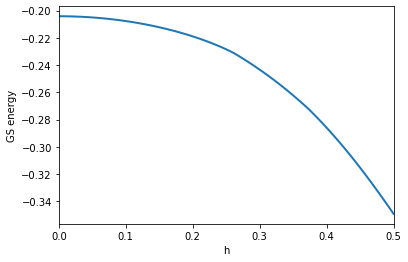

In [12]:
import matplotlib.pyplot as plt
  
plt.plot(a,e[:,0]/ SiteNum, linewidth = 2)
plt.xlim(0,0.5)
plt.xlabel('h')
plt.ylabel('GS energy')

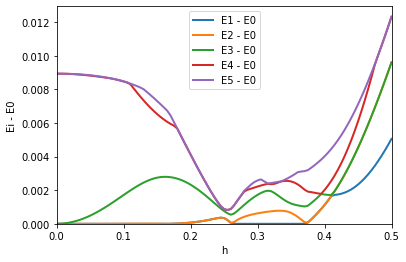

In [13]:
import matplotlib.pyplot as plt

plt.plot(a,(e[:,1] - e[:,0])/ SiteNum, linewidth = 2, label = 'E1 - E0')
plt.plot(a,(e[:,2] - e[:,0])/ SiteNum, linewidth = 2, label = 'E2 - E0')
plt.plot(a,(e[:,3] - e[:,0])/ SiteNum, linewidth = 2, label = 'E3 - E0')
plt.plot(a,(e[:,4] - e[:,0])/ SiteNum, linewidth = 2, label = 'E4 - E0')
plt.plot(a,(e[:,5] - e[:,0])/ SiteNum, linewidth = 2, label = 'E5 - E0')

plt.xlim(0,0.5)
plt.xlabel('h')

plt.ylim(0,)
plt.ylabel('Ei - E0')

plt.legend()

\section{Wilson loop operators}

\subsection{Flux on hexagons}

\quad In Kitaev model, the Wilson loop operator of a hexagon is conserved.
\begin{equation}
    \hat{W}_P = \sigma_0^z \sigma_1^y \sigma_2^x \sigma_3^z \sigma_4^y \sigma_5^x
\end{equation}

\quad We label the hexagon by the position of site-$0$. If the position of site-$0$ is $(r,c)$, then:

| 0       | 1       | 2         | 3           | 4           | 5         |
|---      |---      |---        |---          |---          |---        |
| (r,c)-A | (r,c)-B | (r+1,c)-A | (r+1,c-1)-B | (r+1,c-1)-A | (r,c-1)-B |

<img src = hexagon.png width = "200">


In [ ]:
def unit(N):
    p = identity(pow(2,N))
    return p

def HexFlux(N1, N2, r, c): # can not cross boundary
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    
    # define Pauli matrices
    px = sps.csc_matrix(np.array([[0,1],[1,0]]))
    py = sps.csc_matrix(np.array([[0,-1j],[1j,0]]))
    pz = sps.csc_matrix(np.array([[1,0],[0,-1]]))
    
    # calculate site index
    sites = np.zeros(6, dtype = int)
    sites[0] = index(N1, N2, c, r, atom = 'A')
    sites[1] = index(N1, N2, c, r, atom = 'B')
    sites[2] = index(N1, N2, c, r+1, atom = 'A')
    sites[3] = index(N1, N2, c-1, r+1, atom = 'B')
    sites[4] = index(N1, N2, c-1, r+1, atom = 'A')
    sites[5] = index(N1, N2, c-1, r, atom = 'B')
    
    sites.sort()
    print(sites)
    
    # define Wilson loop operators:5->0->1->4->3->2
    W1 = sps.kron(px, sps.kron(pz,py))  #5->0->1
    W2 = sps.kron(py, sps.kron(pz,px))  #4->3->2
    
    mid = sites[4] - sites[1] - 1
    Wp = sps.kron(unit(sites[5]), W1)
    Wp = sps.kron(Wp, unit(mid))
    Wp = sps.kron(Wp,W2)
    Wp = sps.kron(Wp, unit(SiteNum - sites[5]- mid - 6))
    
    return Wp

In [140]:
J = np.ones(3)
N1 = 3
N2 = 3
SiteNum = N1 * N2 * 2
dim = pow(2, SiteNum)
Hk = KitaevRhom_sparse(J, N1, N2)
from scipy.sparse.linalg import eigsh
e = np.zeros(5)
v = np.zeros([dim,5])
e,v = eigsh(Hk, k = 5,which = 'SA')
print(e/SiteNum)

[-0.19849309 -0.19849309 -0.19548109 -0.19849309 -0.19548109]


In [ ]:
Wp = HexFlux(N1, N2, 2, 1)
w = 0
w = np.conj(v[:,0]).T @ Wp @  v[:,0]
print(w.real)